## Introduction

In this lab, we look at the effect of roughness on surface overland flow, simulating the presence of vegetation. Firstly, we look at a uniform roughness across a hypothetical drainage basin. Next, we use Baptiste’s formula to temporally and spatially update roughness values across the grid, which takes into account relative water depth to vegetation height. 

# Background

The presence of vegetation can greatly alter flow velocity, affecting sediment transport, channel morphology, and biotic habitats. In fluvial systems, vegetation can slow down the flow and increase resistance, leading to the deposition of sediment and the formation of bars and islands. In coastal systems, vegetation can reduce wave energy and erosion, stabilise shorelines, and promote the accumulation of sediments. Despite the importance of vegetation in shaping the evolution of a landscape; the effects are often ignored or over-simplified.

In traditional modelling, the resistance to flow often doesn’t consider the presence of vegetation, which might not help capture the best approximate behaviour of fluvial and coastal processes. In the literature, the Baptist formula is one of the most widely used formulas for vegetated flow (Vargas-Luna, Crosato, and Uijttewaal 2015; Warmink et al. 2011; Berends et al. 2018) and has been adopted in most computational frameworks. The impact of vegetation on flow hydrodynamics is complex and context-dependent, but it plays a critical role in shaping the physical and biological characteristics of fluvial and coastal environments. Modellers shall therefore pay critical attention to the formulas used on a case-by-case basis. 


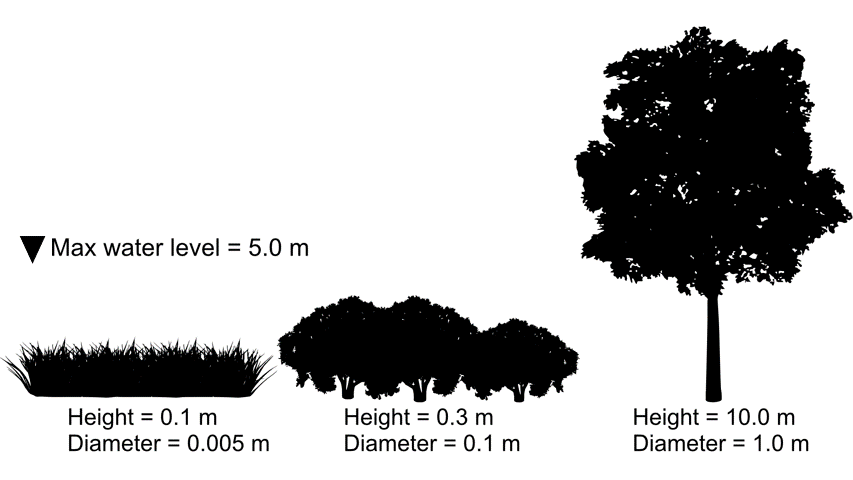

# Load in Libraries

In [18]:
import numpy as np
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import math
import copy

from landlab.components import OverlandFlow
from landlab.io.esri_ascii import read_esri_ascii
from landlab.grid.mappers import map_max_of_node_links_to_node
from landlab.plot import imshow


# Set up RasterModelGrid

First we set up the raster grid, using the Overland flow example DEM.


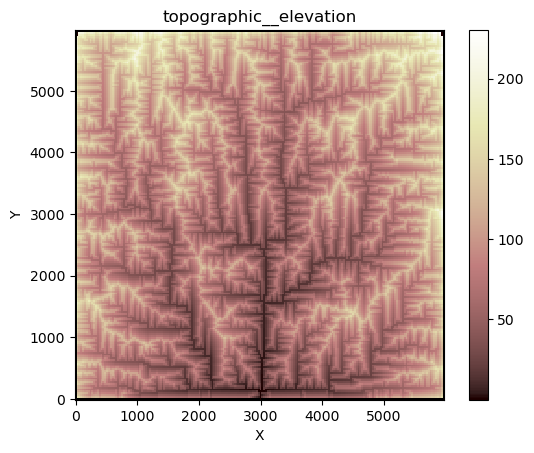

In [3]:
#read in artificially generated raster
grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

#close all boundaries
grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

#open the outlet 
#This DEM was generated using Landlab and the outlet node ID was known
my_outlet_node = 100
grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE

#plot elevation
figure('elevation')
imshow.imshow_grid_at_node(grid, "topographic__elevation")

# Define function for constant roughness

This function defines all the user inputs for a constant bed roughness. We choose a run time of 500 seconds, connect our grid, define boundary conditions and input a constant Manning's n value.

In [4]:
#hydrograph function for constant mannings n
def constantM(n):
    
    #initializing list
    hydrograph_time = []
    discharge_at_outlet = []

    #setting up run time params
    run_time = 500
    elapsed_time = 0.0
    
    #read in artificially generated raster
    grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

    ## Set boundary conditions
    #close all boundaries
    grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

    #open the outlet 
    #This DEM was generated using Landlab and the outlet node ID was known
    my_outlet_node = 100
    grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE
 
    #add surface water depth (1 m everywhere)
    grid.add_ones("surface_water__depth", at = "node", clobber = True)

    #now add roughness
    grid.add_zeros("rough",  at = "node", clobber=True)

    #map roughness to link
    r = grid.map_mean_of_link_nodes_to_link("rough")

    #add to grid
    grid.add_field("mannings_n", r, at = "link", clobber=True)
    
    #initializing Overland flow with a constant n
    of = OverlandFlow(grid,
                      alpha = 0.7,
                      mannings_n = n, 
                      rainfall_intensity=2*(10**-6), #convert mm/hr to m/s
                      steep_slopes=True)
        
    #running the model
    while elapsed_time <= run_time:
        of.dt = of.calc_time_step() # Adaptive time step

        
        of.overland_flow() #run model
        
        #get discharge at outlet link
        outlet = grid.at_link['surface_water__discharge'][299]
        
        hydrograph_time.append(elapsed_time / 3600.) # convert seconds to hours
        discharge_at_outlet.append(np.abs(outlet) * grid.dx) # append discharge in m^3/s
        
        elapsed_time += of.dt #update elapsed time
        
    return grid, hydrograph_time, discharge_at_outlet, elapsed_time # maybe we don't need to see the elapsed time

# Baptist Formula Class

We define a class with two functions:

1. Compute flow resistance (Chezy's coeffiecient) induced by vegetation from vegetation height, stem density, stem diameter and water depth. 

2. In the second function we convert the Chezy's coefficient to Manning's n. We do this because Overland flow inputs Manning's n for roughness.

In [5]:
#class for calc roughness and convert to mannings n
class FlowResistance():
    def Baptist_2007(self, mannings_n, drag_coef, veg_den, veg_diam, veg_height, gravity, van_karman, water_depth):
        bed_roughness = (water_depth**(1/6))/mannings_n
        #The baptist equation 
        Cr1=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) + (np.sqrt(gravity)/van_karman)*np.log(water_depth/veg_height)
        Cr2=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) 
        if (veg_height>=water_depth).all():
            return Cr2
        else:
            return Cr1
        
    def chezy_to_manning(self,water_depth,Chezy):
        #The actual relationship
        n=water_depth**(1/6)/Chezy
        return n

# Define function for dynamic roughness

This function is a variant of the constant roughness function, however, using the class above it takes into account the changing flow resistance (due to effects of vegetation) using the Chezy coeffieceint.

In [6]:
#using variable mannings n value
def newOverlandFlow(den, diam, height, mannings_n):
    
        
    #initializing list
    hydrograph_time = []
    discharge_at_outlet = []
    outlet_m = []
    
    #set up time steps
    run_time = 100
    elapsed_time = 0.0
    
    #read in artificially generated raster
    grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

    #close all boundaries
    grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

    #open the outlet 
    #This DEM was generated using Landlab and the outlet node ID was known
    my_outlet_node = 100
    grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE
 
    #add surface water depth (1 m everywhere)
    grid.add_ones("surface_water__depth", at = "node", clobber = True)

    #now add rouughness
    grid.add_zeros("rough",  at = "node", clobber=True)

    #map roughness to link
    r = grid.map_mean_of_link_nodes_to_link("rough")

    #add to grid
    grid.add_field("mannings_n", r, at = "link", clobber=True)
    
    #initialize model
    of = OverlandFlow(grid, 
                      alpha = 0.7,
                      mannings_n = "mannings_n",
                      rainfall_intensity=2*(10**-6), 
                      steep_slopes=True)
    
    #start loop
    while elapsed_time <= run_time:
        new_manning = []
        for depth in grid.at_link["surface_water__depth"]:
            #call flow resistance class
            flow_resistance = FlowResistance()
            #calculate Chezy's coefficient
            cr = flow_resistance.Baptist_2007(mannings_n=mannings_n, 
                                              drag_coef=1.0, 
                                              veg_den=den, 
                                              veg_diam=diam, 
                                              veg_height=height, 
                                              gravity=9.81, 
                                              van_karman=0.41, 
                                              water_depth=depth)
        
            #convert new chezy to manning
            n=flow_resistance.chezy_to_manning(depth,cr)
            new_manning.append(n)
        
    
        #add new mannings to links
        grid.add_field("mannings_n", new_manning, at = "link", clobber=True)
        of.dt = of.calc_time_step()     # Adaptive time step
        of.overland_flow() #run the model
        
        #get discharge at outlet link
        outlet = grid.at_link['surface_water__discharge'][299]
        m_at_outlet = grid.at_link["mannings_n"][299]
        
        hydrograph_time.append(elapsed_time / 3600.) # convert seconds to hours
        discharge_at_outlet.append(np.abs(outlet) * grid.dx) # append discharge in m^3/s
        outlet_m.append(np.abs(m_at_outlet) * grid.dx)
                                
        elapsed_time += of.dt #update time step
    
    return grid, hydrograph_time, discharge_at_outlet, outlet_m


# Running the models for different vegetation types

Here we take our three vegetation types from the example above and run for both the constant and dynamic flow resistance models:

1. Grass
2. Shrubs 
3. Trees


In [7]:
#running model for grass
# First we run for the constant model
time_constant_grass, discharge_constant_grass = constantM(0.02)[1:3] 

# Then the dynamic
time_variable_grass, discharge_variable_grass, manning_outlet_grass = newOverlandFlow(den = 4500, 
                                                                diam = 0.003,                                                                  
                                                                height = 0.15, 
                                                                mannings_n = 0.02)[1:4] 


#running model for shrubs
time_constant_shrub, discharge_constant_shrub = constantM(0.1)[1:3] 


time_variable_shrub, discharge_variable_shrub, manning_outlet_shrub = newOverlandFlow(den = 500, 
                                                                 diam = 0.01, 
                                                                 height = 0.5, 
                                                                mannings_n = 0.1)[1:4] 


#running model for tree
time_constant_tree, discharge_constant_tree = constantM(0.1)[1:3] 


time_variable_tree, discharge_variable_tree, manning_outlet_tree = newOverlandFlow(den = 1, 
                                                               diam = 0.7, 
                                                               height = 10, 
                                                               mannings_n = 0.1)[1:4] 



# Results!

## Constant roughness hydrograph

The code below plots the constant bed resistance model for grass, shrubs and trees, over our model domain.

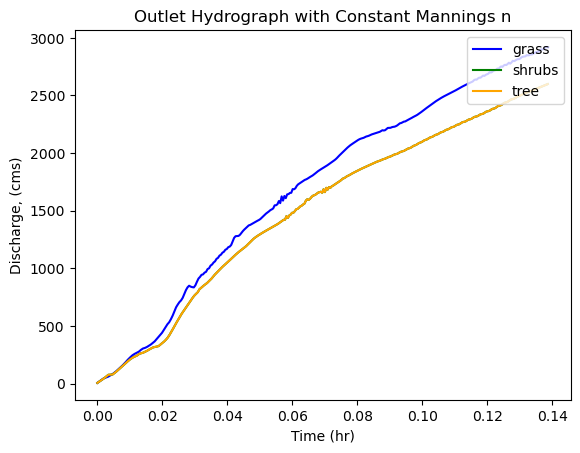

In [8]:
#plot hydrograph at outlet link
plt.plot(time_constant_grass, discharge_constant_grass, label = "grass", color = "blue")
plt.plot(time_constant_shrub, discharge_constant_shrub, label = "shrubs", color = "green")
plt.plot(time_constant_tree, discharge_constant_tree, label = "tree", color = "orange")
plt.legend(loc = "upper right")
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph with Constant Mannings n')
plt.show()

You might notice that there are only two lines! This is because both the shrubs and trees have the same roughness value. (All models are wrong!)

## Dynamic flow resistance hydrograph

As with our constant bed roughness graph, we are now looking at the dynamic model. This time our results are not the same for trees and shrubs. This is because we are taking into account more factors, such as vegetation stem diameter, number of stems per meter and depth of water relative to vegetation height.

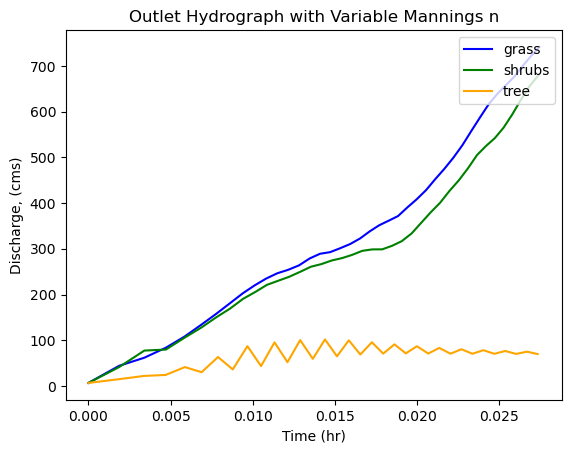

In [10]:
#plot hydrograph at outlet link
plt.plot(time_variable_grass, discharge_variable_grass, label = "grass", color = "blue")
plt.plot(time_variable_shrub, discharge_variable_shrub, label = "shrubs", color = "green")
plt.plot(time_variable_tree, discharge_variable_tree, label = "tree", color = "orange")
plt.legend(loc = "upper right")
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph with Variable Mannings n')
plt.show()

# What is wrong with this graph?!

The discharge value for trees fluctuates unnaturally, and is significantly lower than the other values. This is because of its high 'numerical' flow resistance. In reality it is unlikely that the hydrograph over a woodland would look like this. The Baptiste formula is predominantly used for submerged riparian vegetation. We can check the high flow resistance due to the trees by plotting discharge at the outlet against manning's n values. 

# Manning's n vs discharge scatterplot

What is wrong with this figure?

Again we can see that the Manning's n values are high and not represantive of the real world.

In the real world we wouldn't have a constant high density across the whole domain, and would seek to discretise across the spatially variable domain.


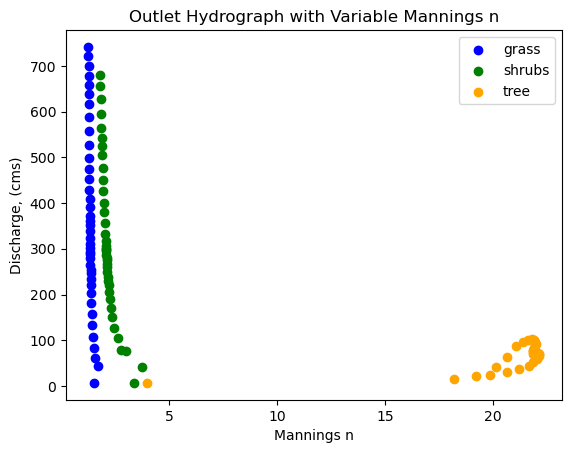

In [11]:
#plot hydrograph at outlet link
plt.scatter(manning_outlet_grass, discharge_variable_grass, label = "grass", color = "blue")
plt.scatter(manning_outlet_shrub, discharge_variable_shrub, label = "shrubs", color = "green")
plt.scatter(manning_outlet_tree, discharge_variable_tree, label = "tree", color = "orange")
plt.legend(loc = "upper right")
plt.xlabel('Mannings n')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph with Variable Mannings n')
plt.show()

## Constant roughness water depth

Here we plot the water depth for grass at the last time step. Note the water depth due to the artificial DEM.

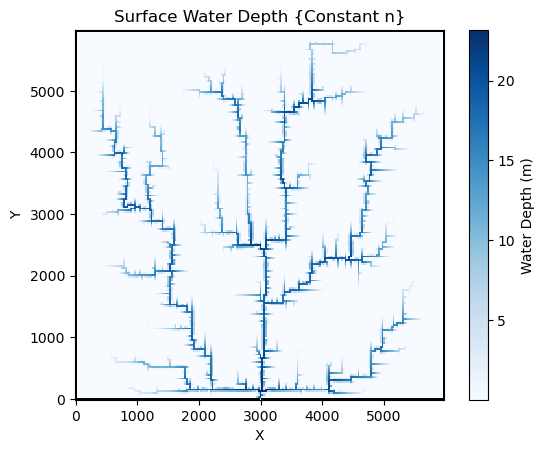

In [9]:
#run function and return grid
grass_constant_m = constantM(n = 0.02)[0]

#figure showing water depth on grid
figure('water depth')
imshow.imshow_grid(grass_constant_m, "surface_water__depth", 
                   cmap = 'Blues', 
                   plot_name = 'Surface Water Depth {Constant n}', 
                   var_name = 'Water Depth (m)')

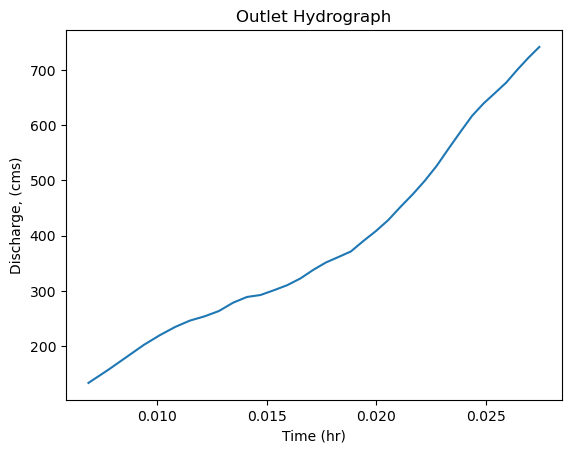

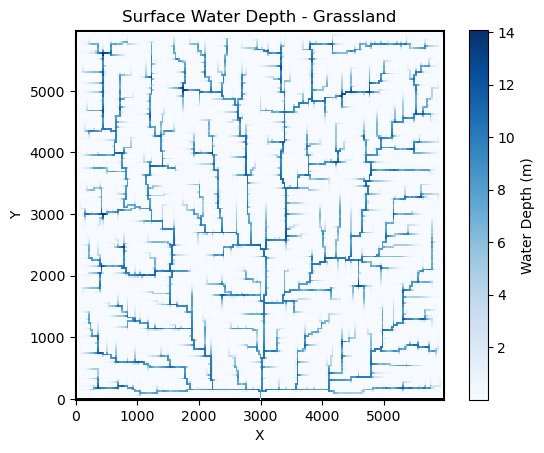

In [12]:
time, discharge = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15, mannings_n = 0.02)[1:3] # https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html
plt.plot(time[5:], discharge[5:])
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph')
plt.show()


# calculate the roughness for different vegetation

# Veg 1 - grassland
# varrying n
#print(newOverlandFlow(den = 10000, diam = 0.003, height = 0.15, mannings_n = 0.02)[1])
grass_varying_n = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15, mannings_n = 0.02)[0]
#figure('water depth')
imshow.imshow_grid(grass_varying_n,  "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth - Grassland', # figure out how to change title
                           var_name = 'Water Depth (m)',
                           at = 'node')
#print(len(new_manning))
#print(grid.number_of_links)
#print(elapsed_time)

In [14]:
imshow.imshow_grid(grass_varying_n-grass_constant_m,  "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth - Grassland', # figure out how to change title
                           var_name = 'Water Depth (m)',
                           at = 'node')


TypeError: unsupported operand type(s) for -: 'RasterModelGrid' and 'RasterModelGrid'

AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

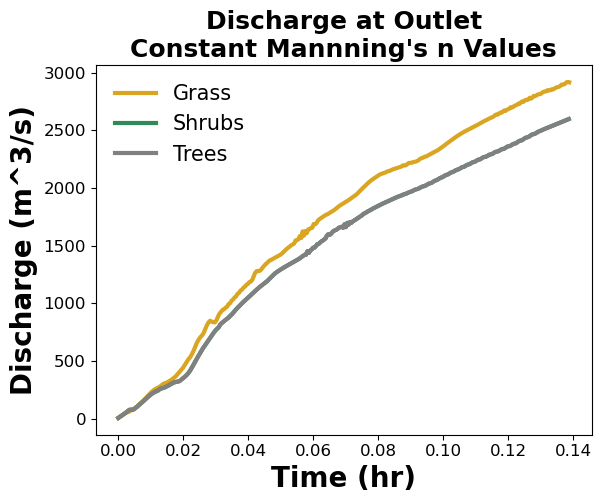

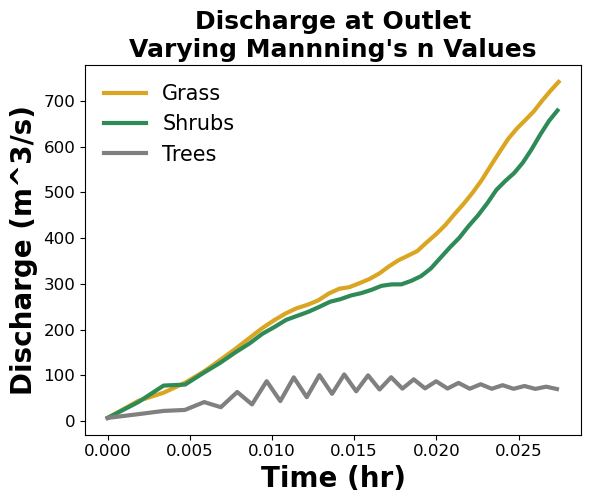

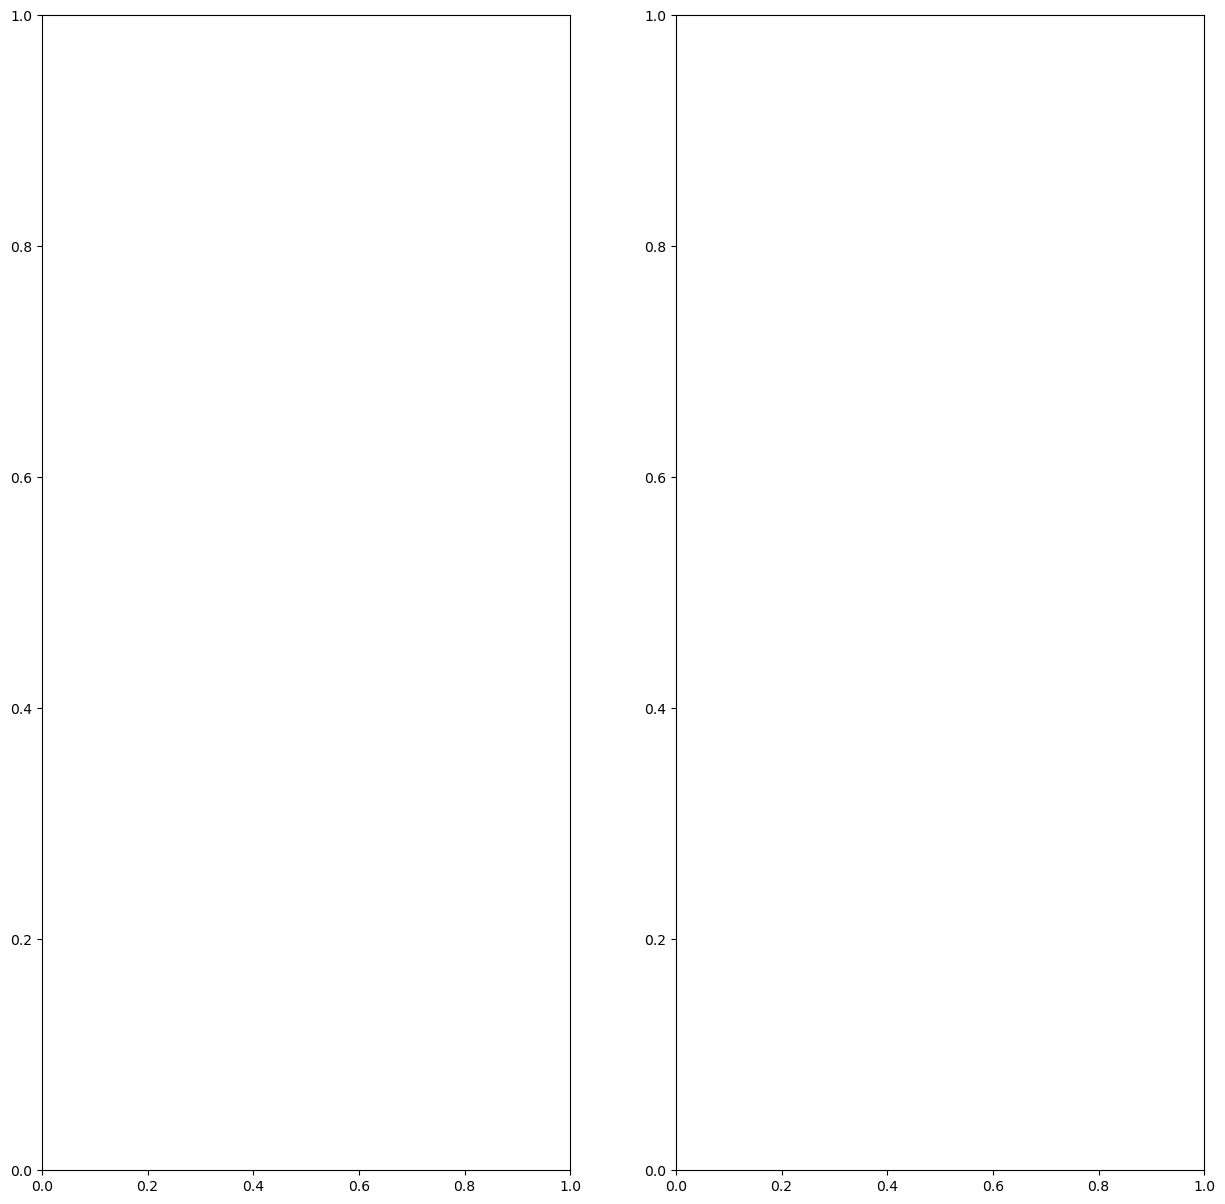

In [19]:
import matplotlib.transforms as mtransforms

#plot hydrograph at outlet link
constant_n, ax = plt.subplots()
plt.plot(time_constant_grass, discharge_constant_grass, label = "Grass", color = 'goldenrod', linewidth=3)
plt.plot(time_constant_shrub, discharge_constant_shrub, label = "Shrubs", color = '#2e8b57', linewidth =3)
plt.plot(time_constant_tree, discharge_constant_tree, label = "Trees", color = 'grey', linewidth=3)
plt.legend(loc='upper left', fontsize=15, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time (hr)', size = 20, weight = 'bold')
plt.ylabel('Discharge (m^3/s)', size = 20, weight = 'bold')
plt.title("Discharge at Outlet\nConstant Mannning's n Values", size = 18, weight = 'bold')

#plot hydrograph at outlet link
varying_n, ax = plt.subplots()
plt.plot(time_variable_grass, discharge_variable_grass, label = "Grass", color = 'goldenrod', linewidth=3)
plt.plot(time_variable_shrub, discharge_variable_shrub, label = "Shrubs", color = '#2e8b57', linewidth =3)
plt.plot(time_variable_tree, discharge_variable_tree, label = "Trees", color = 'gray', linewidth=3)
plt.legend(loc='upper left', fontsize=15, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time (hr)', size = 20, weight = 'bold')
plt.ylabel('Discharge (m^3/s)', size = 20, weight = 'bold')
plt.title("Discharge at Outlet\nVarying Mannning's n Values", size = 18, weight = 'bold')

fig3, ax3 = plt.subplots(ncols=2, nrows = 1, figsize=(15,15))
ax3[0].imshow(constant_n.canvas.renderer.buffer_rgba())
ax3[1].imshow(varying_n.canvas.renderer.buffer_rgba())
ax3[0].axis('off')
ax3[1].axis('off') 
